In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Conv1D, GlobalMaxPooling1D, Add, Attention, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score











In [ ]:
# # Load anime data
# from google.colab import files
# uploaded = files.upload()
#

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
movie_data=pd.read_csv('movie.csv')
movie_data = movie_data.dropna(subset=['genres'])
movie_data = movie_data.drop_duplicates(subset=['title'])

# Combine relevant text features into a single 'content' column
movie_data['content'] = movie_data['genres'] + ' ' + movie_data['title']

# Tokenize and compute TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movie_data['content'])

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)



In [21]:
def get_content_based_recommendations(movie_title, cosine_sim=cosine_sim, movie_data=movie_data):
    movie_title = movie_title.lower()
    movie_titles_lower = movie_data['title'].str.lower()
    if movie_title not in movie_titles_lower.values:
        return []  # Return empty list if movie not found
    movie_idx = movie_data.index[movie_titles_lower == movie_title].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[movie_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get top 10 similar movies (excluding itself)
    recommendations = [{'title': movie_data.iloc[i[0]]['title'], 'genres': movie_data.iloc[i[0]]['genres'], 'score': i[1]} for i in sim_scores]
    return recommendations

In [5]:
df = pd.read_csv('rating.csv')

# Encode user and movie IDs
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [6]:
N = len(set(df['new_user_id']))
M = len(set(df['new_movie_id']))

# Embedding dimension
K = 12

X = np.array([df['new_user_id'], df['new_movie_id']]).T
y = df['rating'].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)




In [8]:
scaler = StandardScaler(with_std=False)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

In [9]:
X_train_reshaped = list(X_train.T)
X_test_reshaped = list(X_test.T)

In [10]:
# Input layers
u = Input(shape=(1,))
m = Input(shape=(1,))

# Embedding layers for collaborative filtering
u_emb = Embedding(N, K)(u)
m_emb = Embedding(M, K)(m)

# Flatten the embeddings
u_emb = Flatten()(u_emb)
m_emb = Flatten()(m_emb)

# Autoencoder for User Embedding
u_encoded = Dense(K // 2, activation='relu')(u_emb)
u_decoded = Dense(K, activation='relu')(u_encoded)
u_autoencoder = Model(u, u_decoded)
u_encoded_output = u_autoencoder(u)

# Autoencoder for Movie Embedding
m_encoded = Dense(K // 2, activation='relu')(m_emb)
m_decoded = Dense(K, activation='relu')(m_encoded)
m_autoencoder = Model(m, m_decoded)
m_encoded_output = m_autoencoder(m)

# Combine encoded user and movie embeddings
x = Concatenate()([u_encoded_output, m_encoded_output])
x = Reshape((2, K))(x)  # Reshape for CNN

# CNN Layer for Feature Extraction
x = Conv1D(filters=64, kernel_size=2, activation='relu')(x)
cnn_output = GlobalMaxPooling1D()(x)

# Attention Mechanism
query = Dense(64)(cnn_output)
key = Dense(64)(cnn_output)
value = Dense(64)(cnn_output)
attention_output = Attention()([query, key, value])

# Combine CNN and Attention outputs
combined = Add()([cnn_output, attention_output])
# Dense layers (Final Prediction Layer)
x = Flatten()(combined)
x = Dense(128, activation='relu')(x)  # Reduce number of neurons to 128
x = Dropout(0.5)(x)
x = Dense(1)(x)

model = Model(inputs=[u, m], outputs=x)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9),
              loss='mse',
              metrics=['accuracy'])






In [13]:
# Train the model
r = model.fit(x=X_train_reshaped, y=y_train_scaled,
              validation_data=(X_test_reshaped, y_test_scaled),
              epochs=25,
              batch_size=1024,
              verbose=2)

Epoch 1/25
1208/1208 - 53s - loss: 0.9677 - accuracy: 0.0000e+00 - val_loss: 0.8164 - val_accuracy: 0.0000e+00 - 53s/epoch - 44ms/step
Epoch 2/25
1208/1208 - 54s - loss: 0.7930 - accuracy: 0.0000e+00 - val_loss: 0.7604 - val_accuracy: 0.0000e+00 - 54s/epoch - 45ms/step
Epoch 3/25
1208/1208 - 54s - loss: 0.7612 - accuracy: 0.0000e+00 - val_loss: 0.7463 - val_accuracy: 0.0000e+00 - 54s/epoch - 44ms/step
Epoch 4/25
1208/1208 - 53s - loss: 0.7492 - accuracy: 0.0000e+00 - val_loss: 0.7411 - val_accuracy: 0.0000e+00 - 53s/epoch - 44ms/step
Epoch 5/25
1208/1208 - 52s - loss: 0.7440 - accuracy: 0.0000e+00 - val_loss: 0.7392 - val_accuracy: 0.0000e+00 - 52s/epoch - 43ms/step
Epoch 6/25
1208/1208 - 54s - loss: 0.7386 - accuracy: 0.0000e+00 - val_loss: 0.7421 - val_accuracy: 0.0000e+00 - 54s/epoch - 45ms/step
Epoch 7/25
1208/1208 - 54s - loss: 0.7330 - accuracy: 0.0000e+00 - val_loss: 0.7325 - val_accuracy: 0.0000e+00 - 54s/epoch - 44ms/step
Epoch 8/25
1208/1208 - 54s - loss: 0.7275 - accuracy: 0

In [26]:
np.sqrt(.7017)

0.8376753547765388

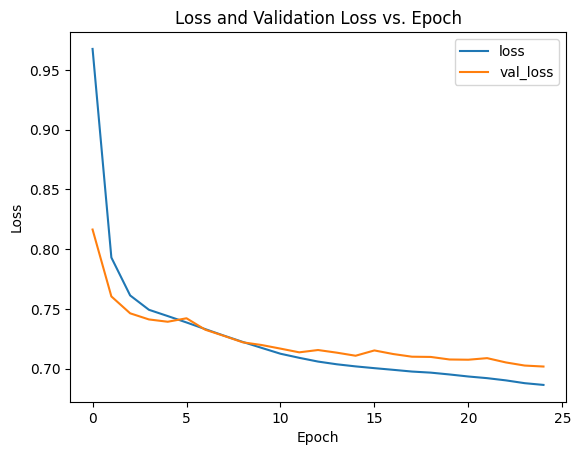

In [14]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Loss and Validation Loss vs. Epoch")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:
def get_collaborative_recommendations(user_id, top_n=10):
    # Ensure user_id is correctly mapped
    if user_id not in df.userId.cat.categories:
        return []  # Return empty list if user_id is not found
    user_id_idx = df.userId.cat.categories.get_loc(user_id)
    user_input = np.array([user_id_idx] * M)
    movie_input = np.array(range(M))
    predictions = model.predict([user_input, movie_input])
    predicted_ratings = predictions.flatten()
    top_indices = np.argsort(predicted_ratings)[-top_n:]

    recommendations = []
    for i in top_indices:
        title = df.movieId.cat.categories[i]
        genres = movie_data.loc[movie_data['title'] == title, 'genres']
        if not genres.empty:
            recommendations.append({'title': title, 'genres': genres.values[0], 'score': predicted_ratings[i]})
    return recommendations

In [25]:
def hybrid_recommendations(movie_title, user_id, content_weight=0.5):
    content_recs = get_content_based_recommendations(movie_title)
    collaborative_recs = get_collaborative_recommendations(user_id)

    # Combine recommendations
    blended_recs = {}
    for rec in content_recs:
        if rec['title'] not in blended_recs:
            blended_recs[rec['title']] = {'genres': rec['genres'], 'score': content_weight * rec['score']}
        else:
            blended_recs[rec['title']]['score'] += content_weight * rec['score']

    for rec in collaborative_recs:
        if rec['title'] not in blended_recs:
            blended_recs[rec['title']] = {'genres': rec['genres'], 'score': (1 - content_weight) * rec['score']}
        else:
            blended_recs[rec['title']]['score'] += (1 - content_weight) * rec['score']

    # Sort recommendations by score
    blended_recs = sorted(blended_recs.items(), key=lambda x: x[1]['score'], reverse=True)

    return [{'title': rec[0], 'genres': rec[1]['genres'], 'score': rec[1]['score']} for rec in blended_recs[:10]]

# Example usage
print(hybrid_recommendations('Toy Story (1995)', 2))

492/492 [==============================] - 1s 2ms/step
[{'title': 'Toy Story 2 (1999)', 'genres': 'Adventure|Animation|Children|Comedy|Fantasy', 'score': 0.43713017361467493}, {'title': 'Toy Story 3 (2010)', 'genres': 'Adventure|Animation|Children|Comedy|Fantasy|IMAX', 'score': 0.40725128906036073}, {'title': 'Toy Story of Terror (2013)', 'genres': 'Animation|Children|Comedy', 'score': 0.3482669889046556}, {'title': 'Toy Story That Time Forgot (2014)', 'genres': 'Animation|Children', 'score': 0.29207145262255085}, {'title': 'Toy Story Toons: Small Fry (2011)', 'genres': 'Adventure|Animation|Children|Comedy|Fantasy', 'score': 0.28972770285623894}, {'title': 'Toy Story Toons: Hawaiian Vacation (2011)', 'genres': 'Adventure|Animation|Children|Comedy|Fantasy', 'score': 0.28799007149378103}, {'title': 'Tin Toy (1988)', 'genres': 'Animation|Children', 'score': 0.2627777689162044}, {'title': 'Toy, The (1982)', 'genres': 'Comedy', 'score': 0.26119373721784}, {'title': 'Toy Story Toons: Partysa